In [74]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from math import sqrt, cos, sin
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A_MAX = 100.0
F_MAX = 100.0

#Original action space included 'spawn' as the sixth action based on the project proposal
PRIMARY_ACTIONS = ['idle', 'thrust_in', 'thrust_out', 'thrust_tangential', 'harvest']

OBS_DIM = 7
ACT_DIM = len(PRIMARY_ACTIONS)

In [76]:
class Drone:
    """
    Basic autonomous agent with position, velocity, fuel, and anti-gravity energy.
    Used for both drone satellites and mothership (is_mothership=True).

    The agent can:
      - Track its position/velocity
      - Consume fuel when applying thrust
      - Store anti-gravity (A) and fuel (F)
      - Report distance and radius from the black hole
    """

    def __init__(self, id, x, y, vx=0.0, vy=0.0,
                 A=A_MAX / 2, F=F_MAX / 2, is_mothership=False):
        # Unique agent identifier
        self.id = id

        # Position in cartesian coordinates
        self.x = float(x)
        self.y = float(y)

        # Velocity vector
        self.vx = float(vx)
        self.vy = float(vy)

        # Anti-gravity charge and fuel levels
        self.A = float(A)
        self.F = float(F)

        # State flags
        self.alive = True
        self.is_mothership = is_mothership

        # Communication + child-tracking (if mothership spawns drones)
        # this is to be implemented in an improved version of this game
        self.last_broadcast = None
        self.spawned_children = []

    def pos(self):
        """Return the agent's (x, y) position as a NumPy array."""
        return np.array([self.x, self.y])

    def radius(self):
        """Distance from the black hole center (r = sqrt(x^2 + y^2))."""
        return sqrt(self.x * self.x + self.y * self.y)

    def distance_to(self, other):
        """Euclidean distance to another agent."""
        return np.linalg.norm(self.pos() - other.pos())

    def apply_thrust(self, ax, ay, dt, c_move=1.0):
        """
        Apply a thrust acceleration vector for time dt.
        
        Fuel consumption is proportional to acceleration magnitude:
        fuel_needed = c_move * |a| * dt

        If insufficient fuel is available, thrust is scaled down so the
        agent never consumes more fuel than it has.
        
        Returns:
            (fuel_used, thrust_magnitude)
        """
        thrust_mag = np.hypot(ax, ay)
        fuel_needed = c_move * thrust_mag * dt

        # No thrust possible without fuel
        if self.F <= 0:
            return 0.0, 0.0

        # Scale thrust down if we don't have enough fuel
        if fuel_needed > self.F:
            scale = self.F / fuel_needed
            ax *= scale
            ay *= scale
            fuel_needed = self.F

        # Update velocity based on final scaled acceleration
        self.vx += ax * dt
        self.vy += ay * dt

        # Deduct consumed fuel
        self.F -= fuel_needed
        return fuel_needed, thrust_mag

    def spend_fuel(self, amount):
        """
        Consume up to `amount` fuel. Never goes negative.
        Returns how much fuel was actually used.
        """
        used = min(self.F, float(amount))
        self.F -= used
        return used

In [77]:
class Mothership(Drone):
    def __init__(self, id, x, y, **kwargs):
        super().__init__(id, x, y, is_mothership=True, **kwargs)

In [78]:
def obs_to_vec(agent_obs):
    """Convert single-agent obs dict from the BlackHoleEnv to 1D numpy array."""
    if agent_obs is None:
        return None
    x, y = agent_obs["self_pos"]
    vx = agent_obs["vx"]
    vy = agent_obs["vy"]
    r  = agent_obs["r"]
    A  = agent_obs["A"]
    F_ = agent_obs["F"]
    return np.array([x, y, vx, vy, r, A, F_], dtype=np.float32)

In [79]:
def reward_blackhole_circular_orbit(agent, t, r, prev_r=None):
    """
    Reward shaping for a drone in a circular orbit environment around a black hole.
    This reward function encourages inward movement, stable orbits inside the ISCO,
    and penalizes drifting too close to the event horizon.
    """
    
    # If the agent has already died, give a strong negative reward.
    if not agent.alive:
        return -300.0

    reward = 0.0

    # Key radii
    RS = 2.0
    ISCO = 8.0
    MID = (RS + ISCO) / 2.0

    # Check if the agent crossed into the ISCO this step
    if prev_r is not None and prev_r > ISCO and r <= ISCO:
        entered_isco = True
    else:
        entered_isco = False


    # Outside the ISCO
    if r > ISCO:
        # Mild penalty for hanging out far from the belt
        if r > ISCO:
            reward -= 0.005 * (r - ISCO) 

        # Reward moving inward (prev_r > r)
        if prev_r is not None and prev_r > r:
            reward += 40.0 

        # ISCO crossing bonus (rare and important)
        if entered_isco:
            reward += 250.0 

    # Inside the ISCO (but outside the event horizon)
    if RS < r <= ISCO:
        # Prefer staying near the center of the belt
        offset = r - MID
        reward += 40.0 * np.exp(-0.3 * (offset ** 2))

        # Compute velocity components in radial/tangential directions
        inv_r = 1.0 / r
        nx, ny = agent.x * inv_r, agent.y * inv_r  # radial unit vector

        tangential_vel = abs(agent.vx * -ny + agent.vy * nx)
        radial_vel     =      agent.vx *  nx + agent.vy * ny

        # Encourage tangential motion (orbital stability)
        reward += 0.4 * tangential_vel

        # Discourage radial drift (falling inward or bouncing outward)
        reward -= 0.5 * abs(radial_vel)

        # Small bonus for maintaining anti-gravity reserves
        reward += 0.05 * agent.A

        # Surviving inside the belt is good on its own
        reward += 8.0

    # Near the event horizon
    danger_zone = RS + 0.3
    if r < danger_zone:
        reward -= 200.0 * (danger_zone - r)

    # Fine tuned enalty for excessive overall speed
    #reward -= 0.5 * np.hypot(agent.vx, agent.vy)
    #reward -= 0.005 * np.hypot(agent.vx, agent.vy)
    reward -= 0.0005 * np.hypot(agent.vx, agent.vy)

    return float(reward)

In [80]:
def reward_blackhole_newtonian_orbit(agent, t, r, prev_r=None):
    """
    Reward shaping for a drone in a newtonian orbit environment around a black hole.
    This reward function encourages inward movement, stable orbits inside the ISCO,
    and penalizes drifting too close to the event horizon.
    """
    # Strong negative reward when an agent dies
    if not agent.alive:
        return -300.0

    total = 0.0

    # Key radii for shaping
    r_s = 2.0        # event horizon
    r_ISCO = 8.0     # inner stable circular orbit boundary
    r_mid = 0.5 * (r_ISCO + r_s)   # target radius inside ISCO

    # Track when a drone crosses from outside ISCO → inside ISCO
    crossed_ISCO = (
        prev_r is not None and
        prev_r > r_ISCO and
        r <= r_ISCO
    )

    # ----------------------------------------------------------------------
    # Outside ISCO: encourage agents to move inward toward the belt
    # ----------------------------------------------------------------------
    if r > r_ISCO:
        # Small penalty the farther away the agent is from ISCO
        total -= 0.005 * (r - r_ISCO)

        # Give a large reward when the agent decreases its radius
        if prev_r is not None and (prev_r - r) > 0:
            total += 40.0

    # Bonus when the agent first enters the ISCO region
    if crossed_ISCO:
        total += 250.0

    # ----------------------------------------------------------------------
    # Inside ISCO: encourage stable orbiting behavior near r_mid
    # ----------------------------------------------------------------------
    if r_s < r <= r_ISCO:

        # Reward staying near the center of the belt (smooth radial shaping)
        dist = r - r_mid
        total += 40.0 * np.exp(-0.3 * dist * dist)

        # Reward tangential (orbital) velocity
        tangential = abs(agent.vx * (-agent.y / r) + agent.vy * (agent.x / r))
        total += 0.4 * tangential

        # Penalize radial movement (falling inward or drifting outward)
        radial = agent.vx * (agent.x / r) + agent.vy * (agent.y / r)
        total -= 0.5 * abs(radial)

        # Small reward for maintaining anti-gravity fuel
        total += 0.05 * agent.A

        # Constant reward for surviving inside the belt
        total += 8.0

    # ----------------------------------------------------------------------
    # Strong penalty for getting dangerously close to the event horizon
    # ----------------------------------------------------------------------
    if r < r_s + 0.3:
        total -= 200.0 * (r_s + 0.3 - r)

    # Tiny penalty on total velocity to reduce chaotic motion
    total -= 0.0005 * np.hypot(agent.vx, agent.vy)

    return float(total)

In [81]:
class MARLBlackHoleEnv:
    """
    A multi-agent environment simulating orbital dynamics around a black hole.

    Two modes are supported:
      - "newtonian":     agents follow Newtonian gravity and naturally spiral inward inside the ISCO.
      - "circular":      agents can enter stable circular orbits using a locking mechanic.
                         An agent locks into a circular orbit when: it chooses the "idle" action (inner or outer region) 
                         OR 
                         its fuel reaches zero (outer region only).

    The environment contains:
      - 1 mothership
      - Several drone agents
      - Resource nodes that provide fuel or anti-gravity (A)
    """

    def __init__(self, n_satellites=5, seed=None, reward_fn=None, orbit_mode="newtonian"):
        if orbit_mode not in ("newtonian", "circular"):
            raise ValueError("orbit_mode must be 'newtonian' or 'circular'")

        self.orbit_mode = orbit_mode

        # Black hole parameters
        self.G = 1.0             # gravitational constant
        self.M = 1.0             # mass of the black hole
        self.r_s = 2.0           # event horizon radius
        self.r_ISCO = 4 * self.r_s   # radius of innermost stable circular orbit
        self.dt = 0.005          # time step

        # Parameters affecting instability inside ISCO
        self.k_plunge = 25.0         # strength of the inner plunge force
        self.A_shield_rate = 6.0     # rate at which anti-gravity is drained inside ISCO
        self.L_damp_rate = 7.0       # exponential decay of tangential momentum inside ISCO

        # Random number generator for spawning and resource distribution
        self.rng = np.random.RandomState(seed)

        self.n_sat = n_satellites
        self.reward_fn = reward_fn

        self.agents = []
        self.next_id = 0
        self.t = 0

        # Two lists for resource nodes so that dead/respawning nodes can be cleanly managed
        self.resource_nodes = []
        self.dead_resource_nodes = []

        self.max_steps = 2000
        self.trajectory_log = []

        self.reset()

    def current_step(self):
        """Return the number of simulation steps elapsed."""
        return self.t

    # Physics helpers
    def acceleration_radial(self, r):
        """Compute radial gravitational acceleration."""
        return -self.G * self.M / max(r**2, 1e-6)

    def circular_velocity(self, r):
        """Return the tangential velocity required for a circular orbit at radius r."""
        return np.sqrt(self.G * self.M / max(r, 1e-6))

    def force_circular_orbit(self, agent):
        """Assign perfect tangential velocity for a circular orbit at the agent's radius."""
        r = agent.radius()
        if r <= 0:
            return

        ux = agent.x / r
        uy = agent.y / r
        tx = -uy          # tangential unit vector
        ty = ux

        v = self.circular_velocity(r)
        agent.vx = v * tx
        agent.vy = v * ty

    # Environment reset
    def reset(self):
        """Reset environment state, agents, and resources."""
        self.agents = []
        self.next_id = 0
        self.t = 0

        # Spawn mothership outside the ISCO
        r0 = self.r_ISCO * 1.2
        m = Mothership(self.next_id, r0, 0.0, A=100, F=100)
        m.locked_orbit = False
        self.next_id += 1
        self.agents.append(m)

        # Spawn drone satellites in roughly stable orbits outside/around ISCO
        for _ in range(self.n_sat):
            r = self.rng.uniform(self.r_ISCO * 0.9, self.r_ISCO * 1.5)
            th = self.rng.uniform(0, 2 * np.pi)
            x = r * np.cos(th)
            y = r * np.sin(th)

            ux = np.cos(th)
            uy = np.sin(th)
            tx = -uy
            ty = ux
            v = self.circular_velocity(r)

            d = Drone(self.next_id, x, y, vx=v * tx, vy=v * ty, A=50, F=50)
            d.locked_orbit = False
            self.next_id += 1
            self.agents.append(d)

        # Resource nodes appear in different radial regions
        self.resource_nodes = []
        self.dead_resource_nodes = []

        # Anti-gravity nodes near horizon (very inner region)
        for _ in range(4):
            th = self.rng.uniform(0, 2 * np.pi)
            r = self.rng.uniform(self.r_s * 1.05, self.r_s * 1.20)
            self.resource_nodes.append({
                "x": r * np.cos(th),
                "y": r * np.sin(th),
                "type": "anti",
                "amount": self.rng.uniform(10, 25),
                "respawn_cooldown": self.rng.randint(150, 300),
                "respawn_timer": 0
            })

        # Anti-gravity nodes in mid region between horizon and ISCO
        for _ in range(15):
            th = self.rng.uniform(0, 2 * np.pi)
            r = self.rng.uniform(self.r_s * 1.2, self.r_ISCO * 0.95)
            self.resource_nodes.append({
                "x": r * np.cos(th),
                "y": r * np.sin(th),
                "type": "anti",
                "amount": self.rng.uniform(15, 35),
                "respawn_cooldown": self.rng.randint(120, 250),
                "respawn_timer": 0
            })

        # Fuel nodes appear outside ISCO
        for _ in range(20):
            th = self.rng.uniform(0, 2 * np.pi)
            r = self.rng.uniform(self.r_ISCO * 1.1, self.r_ISCO * 3.0)
            self.resource_nodes.append({
                "x": r * np.cos(th),
                "y": r * np.sin(th),
                "type": "fuel",
                "amount": self.rng.uniform(10, 25),
                "respawn_cooldown": self.rng.randint(100, 200),
                "respawn_timer": 0
            })

        # Store previous radius for reward or stability checks
        for a in self.agents:
            a.prev_r = a.radius()

        return self._get_obs()

    # Observation builder
    def _get_obs(self):
        """Build per-agent observations containing self state and nearby resources/drones."""
        obs = []
        vision = 3.0    # local sensing radius

        for a in self.agents:
            if not a.alive:
                obs.append(None)
                continue

            # Per-agent view of other drones
            visible_d = []
            for b in self.agents:
                if b is a or not b.alive:
                    continue
                rel = b.pos() - a.pos()
                if np.linalg.norm(rel) <= vision:
                    visible_d.append({
                        "id": b.id,
                        "rel_pos": rel,
                        "vx": b.vx,
                        "vy": b.vy,
                        "A": b.A,
                        "F": b.F,
                        "r": b.radius(),
                    })

            # Per-agent view of nearby resource nodes
            visible_r = []
            for node in self.resource_nodes:
                rel = np.array([node["x"], node["y"]]) - a.pos()
                if np.linalg.norm(rel) <= vision:
                    visible_r.append({
                        "type": node["type"],
                        "rel_pos": rel,
                        "amount": node["amount"],
                    })

            obs.append({
                "self_pos": a.pos(),
                "vx": a.vx,
                "vy": a.vy,
                "r": a.radius(),
                "A": a.A,
                "F": a.F,
                "visible_drones": visible_d,
                "visible_resources": visible_r,
                "r_ISCO": self.r_ISCO,
                "messages": [],
            })

        return obs

    # Simulation step
    def step(self, actions):
        """
        Advance the environment by one time step.

        actions: list of dictionaries, one per agent, containing:
            {"primary": "..."} where primary ∈ {"idle", "harvest", "thrust_in", "thrust_out", "thrust_tangential"}.
        """
        rewards = [0] * len(self.agents)
        dones = [False] * len(self.agents)

        # If in circular-orbit mode, apply orbit-locking rules
        if self.orbit_mode == "circular":
            for idx, agent in enumerate(self.agents):
                if not agent.alive:
                    continue

                r = agent.radius()
                act = actions[idx]["primary"] if actions[idx] else "idle"

                # Outside ISCO: idle or fuel depletion locks orbit immediately
                if r >= self.r_ISCO:
                    if act == "idle" or agent.F <= 0:
                        if not agent.locked_orbit:
                            self.force_circular_orbit(agent)
                            agent.locked_orbit = True
                    continue

                # Inside ISCO: idle locks orbit if agent has anti-gravity available
                if r > self.r_s:
                    if act == "idle" and agent.A > 0 and not agent.locked_orbit:
                        self.force_circular_orbit(agent)
                        agent.locked_orbit = True

                    # Anti-gravity is consumed while locked
                    if agent.locked_orbit:
                        drain = self.A_shield_rate * self.dt
                        agent.A = max(0, agent.A - drain)
                        if agent.A <= 0:
                            agent.locked_orbit = False

                # Inside event horizon = death
                if r <= self.r_s:
                    agent.alive = False

        # Apply thrust or harvesting, unless agent is locked in circular orbit
        for idx, (agent, act) in enumerate(zip(self.agents, actions)):
            if not agent.alive:
                continue

            if self.orbit_mode == "circular" and agent.locked_orbit:
                continue

            if act is None:
                act = {"primary": "idle"}

            primary = act["primary"]
            thrust = 5.0

            if primary in ("thrust_in", "thrust_out", "thrust_tangential"):
                r = agent.radius()
                ux = agent.x / r if r > 0 else 0.0
                uy = agent.y / r if r > 0 else 0.0

                if primary == "thrust_in":
                    ax = -thrust * ux; ay = -thrust * uy
                elif primary == "thrust_out":
                    ax = thrust * ux; ay = thrust * uy
                else:
                    ax = -thrust * uy; ay = thrust * ux

                fuel_used, _ = agent.apply_thrust(ax, ay, self.dt)
                rewards[idx] -= 0.00001 * fuel_used

            elif primary == "harvest":
                gotF = gotA = 0.0
                for node in self.resource_nodes[:]:
                    d = np.linalg.norm(np.array([node["x"], node["y"]]) - agent.pos())
                    if d <= 0.5 and node["amount"] > 0:

                        take = min(node["amount"], self.rng.uniform(2, 8))
                        node["amount"] -= take

                        if node["type"] == "fuel":
                            gotF += take
                        else:
                            gotA += take

                        if node["amount"] <= 0:
                            node["amount"] = 0
                            node["respawn_timer"] = 0
                            self.resource_nodes.remove(node)
                            self.dead_resource_nodes.append(node)

                if gotF > 0:
                    agent.F = min(100, agent.F + gotF)
                    rewards[idx] += 5 * gotF
                if gotA > 0:
                    agent.A = min(100, agent.A + gotA)
                    rewards[idx] += 5 * gotA

        # Physics update: Newtonian dynamics or locked circular motion
        for idx, agent in enumerate(self.agents):
            if not agent.alive:
                continue

            # If orbit-locked, motion is simple uniform circular trajectory
            if self.orbit_mode == "circular" and agent.locked_orbit:
                agent.x += agent.vx * self.dt
                agent.y += agent.vy * self.dt
                agent.prev_r = agent.radius()
                continue

            # Otherwise apply Newtonian physics
            r = agent.radius()
            if r <= self.r_s:
                agent.alive = False
                rewards[idx] -= 1
                dones[idx] = True
                continue

            ux = agent.x / r
            uy = agent.y / r

            # Inside ISCO: angular momentum damping makes orbit unstable
            if self.r_s < r < self.r_ISCO:
                v_r = agent.vx * ux + agent.vy * uy
                v_t = agent.vx * (-uy) + agent.vy * ux

                depth = (self.r_ISCO - r) / (self.r_ISCO - self.r_s)
                L_damp = np.exp(-self.L_damp_rate * depth * self.dt)
                v_t *= L_damp

                agent.vx = v_r * ux + v_t * (-uy)
                agent.vy = v_r * uy + v_t * ux

            # Base gravity
            a_grav = self.acceleration_radial(r)

            # Additional inward force + shield consumption inside ISCO
            extra_in = 0.0
            shield = 0.0
            if self.r_s < r < self.r_ISCO:
                drain = self.A_shield_rate * self.dt
                used = min(agent.A, drain)
                agent.A -= used
                shield = used / (drain + 1e-9)

                a_plunge = -self.k_plunge * self.G * self.M / max(r * r, 1e-6)
                extra_in = (1.0 - shield) * a_plunge

            a_rad = a_grav + extra_in
            ax = a_rad * ux
            ay = a_rad * uy

            # Leapfrog integration (half-step velocity update)
            agent.vx += 0.5 * ax * self.dt
            agent.vy += 0.5 * ay * self.dt

            agent.x += agent.vx * self.dt
            agent.y += agent.vy * self.dt

            # Second half-step
            r2 = agent.radius()
            if r2 <= self.r_s:
                agent.alive = False
                rewards[idx] -= 1
                dones[idx] = True
                continue

            ux2 = agent.x / r2
            uy2 = agent.y / r2

            a_grav2 = self.acceleration_radial(r2)
            extra_in2 = 0.0
            if self.r_s < r2 < self.r_ISCO:
                a_plunge2 = -self.k_plunge * self.G * self.M / max(r2 * r2, 1e-6)
                extra_in2 = (1.0 - shield) * a_plunge2

            a_rad2 = a_grav2 + extra_in2
            ax2 = a_rad2 * ux2
            ay2 = a_rad2 * uy2

            agent.vx += 0.5 * ax2 * self.dt
            agent.vy += 0.5 * ay2 * self.dt

            agent.prev_r = r2

        # Apply user reward function
        if self.reward_fn:
            for idx, agent in enumerate(self.agents):
                if agent.alive:
                    rewards[idx] += self.reward_fn(agent, self.t, agent.radius(), agent.prev_r)

        # Resource node respawn logic
        for node in self.dead_resource_nodes[:]:
            node["respawn_timer"] += 1
            if node["respawn_timer"] >= node["respawn_cooldown"]:
                # Respawn node somewhere appropriate based on type
                th = self.rng.uniform(0, 2 * np.pi)
                if node["type"] == "anti":
                    r = self.rng.uniform(self.r_s * 1.05, self.r_s * 1.20)
                else:
                    r = self.rng.uniform(self.r_ISCO * 1.1, self.r_ISCO * 3.0)

                node["x"] = r * np.cos(th)
                node["y"] = r * np.sin(th)
                node["amount"] = self.rng.uniform(10, 25)
                node["respawn_timer"] = 0

                self.dead_resource_nodes.remove(node)
                self.resource_nodes.append(node)

        # Ensure all nodes in resource_nodes have positive amount
        for node in self.resource_nodes[:]:
            if node["amount"] <= 0:
                node["amount"] = 0
                self.resource_nodes.remove(node)
                self.dead_resource_nodes.append(node)

        # Check episode termination
        if self.t >= self.max_steps:
            env_done = True
        else:
            # Environment ends if mothership dies
            env_done = not any(a.alive for a in self.agents if getattr(a, "is_mothership", False))

        # Build next observation and finish step
        obs = self._get_obs()
        self.t += 1
        self.trajectory_log.append([(a.id, a.x, a.y, a.alive) for a in self.agents])

        return obs, rewards, dones, {"env_done": env_done}


In [82]:
class CurriculumWrapper:
    """
    A wrapper around SimpleBlackHoleEnv that introduces a staged curriculum.

    The idea:
      - Early stages simplify starting conditions so PPO learns basic behaviors.
      - Later stages gradually shift to the full environment.

    Curriculum stages:
      Stage 0: All satellites start outside ISCO. Strong shaping to move inward.
      Stage 1: Half outside ISCO, half inside belt (r_s < r < r_ISCO)
      Stage 2: All satellites start outside but close to the belt; shaping
               encourages entering ISCO and stabilizing.
      Stage 3: No curriculum. Use the environment’s default reset().
    """

    def __init__(
        self,
        env,
        stage0_to_1_episodes=10,
        stage1_to_2_episodes=30,
        stage2_to_3_episodes=100,
        debug=True,
        seed=0,
    ):
        # Wrapped base environment
        self.env = env

        # Current curriculum stage
        self.stage = 0
        self.episodes_seen = 0

        # Thresholds for automatic stage progression
        self.stage0_to_1 = stage0_to_1_episodes
        self.stage1_to_2 = stage1_to_2_episodes
        self.stage2_to_3 = stage2_to_3_episodes

        self.debug = debug
        self.rng = np.random.RandomState(seed)

    def __getattr__(self, name):
        """
        Forward attribute lookups to underlying environment
        unless the wrapper overrides the name.
        """
        # TODO: This might mask attribute errors inside the wrapper.
        #       Consider adding an explicit attribute allowlist
        #       or protecting against infinite recursion if env lacks an attribute.
        return getattr(self.env, name)

    # Curriculum reset 
    def reset(self):
        """
        Reset the underlying env, then reposition satellites based
        on the current curriculum stage.
        """
        # TODO: Might be worth exposing reset args instead of discarding `_`.
        _ = self.env.reset()

        if self.debug:
            print(f"\n[Curriculum] Reset at stage {self.stage}, episode {self.episodes_seen}")

        if self.stage == 0:
            self._init_stage0_satellites()
        elif self.stage == 1:
            self._init_stage1_satellites()
        elif self.stage == 2:
            self._init_stage2_satellites()
        else:
            # Stage 3: no curriculum modifications -> full MARLBlackHoleEnv
            if self.debug:
                print("[Curriculum] Stage 3: using default environment reset")

        obs = self.env._get_obs()

        if self.debug:
            self._debug_reset_summary()

        return obs

    # Curriculum stepper
    def step(self, actions):
        """
        Forward the step call to the environment, then apply stage-specific
        shaping rewards (light-touch reward bonuses).
        """
        next_obs, rewards, dones, info = self.env.step(actions)

        # Stage 0 step
        if self.stage == 0:
            r_ISCO = self.env.r_ISCO

            for i, agent in enumerate(self.env.agents):
                if i == 0 or not agent.alive:
                    continue

                r = agent.radius()
                prev_r = getattr(agent, "prev_r_for_curric", r)

                # Reward inward movement while still outside ISCO
                if prev_r > r_ISCO and r > r_ISCO:
                    inward = prev_r - r
                    if inward > 0:
                        rewards[i] += 5.0 * inward  # TODO: Consider making this a tunable param.

                agent.prev_r_for_curric = r

        # Stage 2 step
        if self.stage == 2:
            r_s = self.env.r_s
            r_ISCO = self.env.r_ISCO

            for i, agent in enumerate(self.env.agents):
                if i == 0 or not agent.alive:
                    continue

                r = agent.radius()
                prev_r = getattr(agent, "prev_r_for_entry", r)

                prev_region = getattr(
                    agent,
                    "prev_region_for_entry",
                    "outside" if prev_r > r_ISCO else "belt" if prev_r > r_s else "inside"
                )

                curr_region = (
                    "inside" if r <= r_s
                    else "belt" if r <= r_ISCO
                    else "outside"
                )

                # Reward inward motion while outside ISCO
                if prev_region == "outside" and curr_region == "outside":
                    inward = prev_r - r
                    if inward > 0:
                        rewards[i] += 1.5 * inward  # TODO: parameterize shaping strength

                # Bonus for entering the belt
                if prev_region == "outside" and curr_region == "belt":
                    rewards[i] += 10.0  # TODO: Maybe scale bonus based on velocity or stability?

                # Small reward for staying inside belt
                if curr_region == "belt":
                    rewards[i] += 0.05  # TODO: Could scale by time or agent performance.

                agent.prev_r_for_entry = r
                agent.prev_region_for_entry = curr_region

        return next_obs, rewards, dones, info

    # Curriculum progression
    def on_episode_end(self, ep_return):
        """
        Called by PPO loop after each episode.
        Increments episode counter and switches curriculum stages.
        """
        self.episodes_seen += 1

        # TODO: Stage progression based on *performance* instead of fixed counts
        #       would make the curriculum adaptive rather than static.
        #       Example: move to next stage when avg reward > threshold.

        # Stage transitions
        if self.stage == 0 and self.episodes_seen >= self.stage0_to_1:
            self.stage = 1
            if self.debug:
                print(f"\n[Curriculum] >>> Entering STAGE 1 (episode {self.episodes_seen})")
            return

        if self.stage == 1 and self.episodes_seen >= (self.stage0_to_1 + self.stage1_to_2):
            self.stage = 2
            if self.debug:
                print(f"\n[Curriculum] >>> Entering STAGE 2 (episode {self.episodes_seen})")
            return

        if self.stage == 2 and self.episodes_seen >= (
            self.stage0_to_1 + self.stage1_to_2 + self.stage2_to_3
        ):
            self.stage = 3
            if self.debug:
                print(f"\n[Curriculum] >>> Entering STAGE 3 (episode {self.episodes_seen})")
            return

    # Stage-specific satellite initialization
    def _init_stage0_satellites(self):
        """
        Stage 0:
          - All satellites placed just outside ISCO
          - Satellites have stable-ish circular velocity
        """
        r_ISCO = self.env.r_ISCO

        for i, agent in enumerate(self.env.agents):
            if i == 0:
                continue  # mothership

            # TODO: Most of this code is redundant + duplicates Stage 1 and Stage 2 logic.
            # Could create a single helper for placing satellites in a radius band.

            r = self.rng.uniform(1.05 * r_ISCO, 1.30 * r_ISCO)
            th = self.rng.uniform(0, 2 * np.pi)

            agent.x = r * np.cos(th)
            agent.y = r * np.sin(th)

            v_circ = self.env.circular_velocity(r)
            v = v_circ * self.rng.uniform(0.95, 1.05)

            ux, uy = np.cos(th), np.sin(th)
            tx, ty = -uy, ux

            agent.vx = v * tx
            agent.vy = v * ty
            agent.F = max(agent.F, 40.0)
            agent.A = max(agent.A, 10.0)

            self._clear_stage2_state(agent)

    def _init_stage1_satellites(self):
        """
        Stage 1:
          - Half outside ISCO
          - Half inside belt
        """
        r_s = self.env.r_s
        r_ISCO = self.env.r_ISCO

        sats = self.env.agents[1:]
        n = len(sats)
        if n == 0:
            return

        # TODO: Uneven split could be tuned based on total satellites.
        half = n // 2

        self.rng.shuffle(sats)

        # Outside half
        for agent in sats[:half]:
            r = self.rng.uniform(1.05 * r_ISCO, 1.30 * r_ISCO)
            th = self.rng.uniform(0, 2 * np.pi)

            agent.x = r * np.cos(th)
            agent.y = r * np.sin(th)

            v_circ = self.env.circular_velocity(r)
            v = v_circ * self.rng.uniform(0.95, 1.05)

            ux, uy = np.cos(th), np.sin(th)
            tx, ty = -uy, ux

            agent.vx = v * tx
            agent.vy = v * ty
            agent.F = max(agent.F, 40.0)
            agent.A = max(agent.A, 15.0)

        # Inside belt half
        for agent in sats[half:]:
            r = self.rng.uniform(r_s + 0.7, r_ISCO - 0.5)
            th = self.rng.uniform(0, 2 * np.pi)

            agent.x = r * np.cos(th)
            agent.y = r * np.sin(th)

            v_circ = self.env.circular_velocity(r)
            v = v_circ * self.rng.uniform(0.95, 1.05)

            ux, uy = np.cos(th), np.sin(th)
            tx, ty = -uy, ux

            agent.vx = v * tx
            agent.vy = v * ty

            agent.A = max(agent.A, 40.0)  # Need A inside belt
            agent.F = max(agent.F, 30.0)

        for agent in sats:
            self._clear_stage2_state(agent)

    def _init_stage2_satellites(self):
        """
        Stage 2:
          - All satellites start outside, close to ISCO.
        """
        r_ISCO = self.env.r_ISCO

        for i, agent in enumerate(self.env.agents):
            if i == 0:
                continue  # mothership untouched

            # TODO: Same pattern as Stage 0 & Stage 1. Factor out radius + velocity setup.
            r = self.rng.uniform(1.10 * r_ISCO, 1.40 * r_ISCO)
            th = self.rng.uniform(0, 2 * np.pi)

            agent.x = r * np.cos(th)
            agent.y = r * np.sin(th)

            v_circ = self.env.circular_velocity(r)
            v = v_circ * self.rng.uniform(0.9, 1.05)

            ux, uy = np.cos(th), np.sin(th)
            tx, ty = -uy, ux

            agent.vx = v * tx
            agent.vy = v * ty
            agent.F = max(agent.F, 35.0)
            agent.A = max(agent.A, 20.0)

            agent.prev_r_for_entry = agent.radius()
            agent.prev_region_for_entry = "outside"

    # TODO: Consider merging _init_stage0_satellites, _init_stage1_satellites,
    #       and _init_stage2_satellites into a single "place_satellite" helper
    #       to remove repeated radius/orbit initialization code.

    def _clear_stage2_state(self, agent):
        """Remove stage-2 tracking fields if they exist."""
        if hasattr(agent, "prev_r_for_entry"):
            del agent.prev_r_for_entry
        if hasattr(agent, "prev_region_for_entry"):
            del agent.prev_region_for_entry

    # Debug printing
    def _debug_reset_summary(self):
        """Print each agent’s radius and region classification."""
        r_s = self.env.r_s
        r_ISCO = self.env.r_ISCO

        counts = {"outside": 0, "belt": 0, "inside_horizon": 0}
        details = []

        for i, a in enumerate(self.env.agents):
            if not a.alive:
                continue

            r = a.radius()
            if r <= r_s:
                region = "inside_horizon"
            elif r <= r_ISCO:
                region = "belt"
            else:
                region = "outside"

            counts[region] += 1
            details.append((i, r, region))

        print("[Curriculum] Reset summary:")
        for idx, r, region in details:
            print(f"  Agent {idx}: r={r:.3f}, region={region}")
        print("  Region counts:", counts)
        print("<><><><><><><><><><>")

In [83]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes=(128, 128)):
        super().__init__()
        # Policy
        layers_pi = []
        last = obs_dim
        for h in hidden_sizes:
            layers_pi += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers_pi += [nn.Linear(last, act_dim)]
        self.pi = nn.Sequential(*layers_pi)

        # Value
        layers_v = []
        last = obs_dim
        for h in hidden_sizes:
            layers_v += [nn.Linear(last, h), nn.ReLU()]
            last = h
        layers_v += [nn.Linear(last, 1)]
        self.v = nn.Sequential(*layers_v)

    def step(self, obs_tensor):
        if obs_tensor.dim() == 1:
            obs_tensor = obs_tensor.unsqueeze(0)
        logits = self.pi(obs_tensor)
        dist = Categorical(logits=logits)
        action = dist.sample()
        logp = dist.log_prob(action)
        value = self.v(obs_tensor).squeeze(-1)
        return action.squeeze(0), logp.squeeze(0), value.squeeze(0)

    def act(self, obs_tensor):
        with torch.no_grad():
            a, _, _ = self.step(obs_tensor)
        return a.item()

In [84]:
class PPOBuffer:
    def __init__(self, obs_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.int64)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)

        self.gamma = gamma
        self.lam = lam
        self.ptr = 0
        self.max_size = size

    def store(self, obs, act, rew, val, logp, done):
        assert self.ptr < self.max_size, "Buffer overflow"
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.done_buf[self.ptr] = float(done)
        self.ptr += 1

    def finish_path(self, last_val=0.0):
        path_len = self.ptr
        vals = np.append(self.val_buf[:path_len], last_val)
        adv = np.zeros(path_len, dtype=np.float32)
        gae = 0.0
        for t in reversed(range(path_len)):
            nonterminal = 1.0 - self.done_buf[t]
            delta = self.rew_buf[t] + self.gamma * vals[t+1] * nonterminal - vals[t]
            gae = delta + self.gamma * self.lam * nonterminal * gae
            adv[t] = gae
        self.adv_buf[:path_len] = adv
        self.ret_buf[:path_len] = adv + self.val_buf[:path_len]

        # normalize advantages
        adv_mean = np.mean(self.adv_buf[:path_len])
        adv_std  = np.std(self.adv_buf[:path_len]) + 1e-8
        self.adv_buf[:path_len] = (self.adv_buf[:path_len] - adv_mean) / adv_std

    def get(self):
        assert self.ptr > 0, "Buffer is empty!"
        data = dict(
            obs=torch.as_tensor(self.obs_buf[:self.ptr], dtype=torch.float32, device=device),
            act=torch.as_tensor(self.act_buf[:self.ptr], dtype=torch.int64, device=device),
            adv=torch.as_tensor(self.adv_buf[:self.ptr], dtype=torch.float32, device=device),
            ret=torch.as_tensor(self.ret_buf[:self.ptr], dtype=torch.float32, device=device),
            logp=torch.as_tensor(self.logp_buf[:self.ptr], dtype=torch.float32, device=device),
        )
        return data


In [85]:
class SharedPPO:
    def __init__(
        self,
        obs_dim,
        act_dim,
        clip_ratio=0.2,
        pi_lr=3e-4,
        vf_lr=1e-3,
        train_pi_iters=80,
        train_v_iters=80,
        target_kl=0.01
    ):
        self.ac = ActorCritic(obs_dim, act_dim).to(device)
        self.clip_ratio = clip_ratio
        self.pi_optimizer = torch.optim.Adam(self.ac.pi.parameters(), lr=pi_lr)
        self.vf_optimizer = torch.optim.Adam(self.ac.v.parameters(), lr=vf_lr)
        self.train_pi_iters = train_pi_iters
        self.train_v_iters = train_v_iters
        self.target_kl = target_kl

    def compute_loss_pi(self, data):
        obs, act, adv, logp_old = data["obs"], data["act"], data["adv"], data["logp"]
        logits = self.ac.pi(obs)
        dist = Categorical(logits=logits)
        logp = dist.log_prob(act)

        ratio = torch.exp(logp - logp_old)
        unclipped = ratio * adv
        clipped = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * adv
        loss_pi = -torch.min(unclipped, clipped).mean()

        approx_kl = (logp_old - logp).mean().item()
        entropy = dist.entropy().mean().item()

        return loss_pi, approx_kl, entropy

    def compute_loss_v(self, data):
        obs, ret = data["obs"], data["ret"]
        v = self.ac.v(obs).squeeze(-1)
        return F.mse_loss(v, ret)

    def update(self, data):
        # policy
        for i in range(self.train_pi_iters):
            self.pi_optimizer.zero_grad()
            loss_pi, kl, entropy = self.compute_loss_pi(data)
            if kl > 1.5 * self.target_kl:
                break
            loss_pi.backward()
            self.pi_optimizer.step()

        # value
        for i in range(self.train_v_iters):
            self.vf_optimizer.zero_grad()
            loss_v = self.compute_loss_v(data)
            loss_v.backward()
            self.vf_optimizer.step()
        return {
        "loss_pi": loss_pi.item(),
        "loss_v": loss_v.item(),
        "kl": kl,
        "entropy": entropy
        }

In [93]:
def train_shared_ppo(
    epochs=50,                     # Number of PPO update cycles.
                                   # 50–500 typical. More epochs = more learning.

    steps_per_epoch=4000,          # How many env-steps to collect per epoch.
                                   # 2000–8000 is standard in PPO. Higher = stabler
                                   # advantage estimates but more computation.

    gamma=0.99,                    # Discount factor. 0.99 is standard for long-term tasks.
                                   # Lower (0.95) makes learning more myopic.

    lam=0.95,                      # GAE parameter. 0.95 gives a good bias/variance tradeoff.
                                   # Higher (0.97–0.99) makes advantages smoother but slower.

    n_satellites=4,
    orbit_mode="newtonian",
    seed=0
):
    """
    Train PPO in the black hole multi-agent environment.

    The design is based on standard OpenAI PPO defaults with small adjustments
    for multi-agent instability and sparse reward signals.
    """

    # Fix RNG for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Create base environment
    base_env = MARLBlackHoleEnv(
        n_satellites=n_satellites,
        seed=seed,
        orbit_mode=orbit_mode,
        reward_fn=reward_blackhole_newtonian_orbit
    )

    # Curriculum helps PPO converge earlier instead of failing on sparse reward
    env = CurriculumWrapper(
        base_env,
        stage0_to_1_episodes=10,     # 10 episodes is enough for PPO to learn basic inward motion
        stage1_to_2_episodes=30,     # 30 episodes gives time to stabilize inside ISCO
        stage2_to_3_episodes=60,     # Longer because this is the hardest part
        debug=False,
        seed=seed,
    )

    n_agents = len(env.agents)

    # PPO network / optimizer hyperparams
    ppo = SharedPPO(
        OBS_DIM,
        ACT_DIM,

        clip_ratio=0.2,              # Standard PPO clipping parameter from the original paper.
                                     # Lower limits policy updates too much, higher destabilizes.

        pi_lr=3e-4,                  # Policy learning rate.
                                     # 3e-4 is a good default: fast enough but avoids divergence.
                                     # 1e-4 → safer but slower. 1e-3 → often explodes.

        vf_lr=1e-3,                  # Value function learns faster since it's supervised.
                                     # If too low → slow critic. Too high → critic oscillation.

        train_pi_iters=80,           # Number of mini-batch updates per epoch.
                                     # Higher = better convergence but slower training.
                                     # PPO paper uses 80 for complex environments.

        train_v_iters=80,            # Same reasoning as above for the value network.

        target_kl=0.015              # Early-stopping threshold.
                                     # 0.01–0.03 is normal. Lower = more conservative updates.
    )

    # These track reward distribution to stabilize PPO advantage scaling.
    rew_mean = 0.0
    rew_var = 1.0
    alpha = 0.01                     # Smooth update rate:
                                     # 0.01 keeps stats stable without lagging too much.

    global_episode = 0

    # History for plotting training curves across epochs
    history = {
        "epoch": [],
        "return": [],
        "loss_pi": [],
        "loss_v": [],
        "entropy": [],
        "kl": [],
    }

    # Main training loop
    for epoch in range(epochs):

        # Buffer holds trajectories until the epoch ends
        buf = PPOBuffer(
            OBS_DIM,
            steps_per_epoch * n_agents,
            gamma=gamma,
            lam=lam,
        )

        obs_list = env.reset()
        last_ep_ret = None
        last_ep_stage = None
        ep_ret = 0.0

        # Collect experience
        for step in range(steps_per_epoch):

            actions_idx = [None] * n_agents
            values = [0.0] * n_agents
            logps = [0.0] * n_agents
            obs_vecs = [None] * n_agents

            # Ask the PPO policy for each agent's action
            for i, agent in enumerate(env.agents):
                if agent is None or not agent.alive or obs_list[i] is None:
                    continue

                obs_vec = obs_to_vec(obs_list[i])
                obs_tensor = torch.as_tensor(obs_vec, dtype=torch.float32, device=device)

                with torch.no_grad():
                    act, logp, val = ppo.ac.step(obs_tensor)

                actions_idx[i] = int(act.item())
                logps[i] = float(logp.item())
                values[i] = float(val.item())
                obs_vecs[i] = obs_vec

            # Convert integer indices -> environment actions
            env_actions = [
                None if a is None else {"primary": PRIMARY_ACTIONS[a], "broadcast": False}
                for a in actions_idx
            ]

            next_obs_list, rewards, dones, info = env.step(env_actions)

            env_done = info.get("env_done", False)
            if env_done:
                dones = [True] * n_agents

            # Update running reward stats for normalization
            batch_mean = np.mean(rewards)
            rew_mean = (1 - alpha) * rew_mean + alpha * batch_mean
            rew_var = (1 - alpha) * rew_var + alpha * np.var(rewards)

            # Normalized reward helps PPO maintain stable gradients
            norm_rewards = (rewards - rew_mean) / (np.sqrt(rew_var) + 1e-8)
            norm_rewards = np.clip(norm_rewards, -10, 10)

            # Store each agent’s transition
            for i in range(n_agents):
                if obs_vecs[i] is None:
                    continue

                buf.store(
                    obs=obs_vecs[i],
                    act=actions_idx[i],
                    rew=norm_rewards[i],
                    val=values[i],
                    logp=logps[i],
                    done=dones[i]
                )

                # Track raw env reward for return logging
                ep_ret += rewards[i]

            # Episode ended; lets reset environment and update curriculum
            if env_done:
                global_episode += 1
                last_ep_ret = ep_ret
                last_ep_stage = env.stage

                if hasattr(env, "on_episode_end"):
                    env.on_episode_end(ep_ret)

                ep_ret = 0.0
                obs_list = env.reset()
            else:
                obs_list = next_obs_list

        # End of epoch; & update PPO using collected trajectories
        buf.finish_path(last_val=0.0)
        data = buf.get()
        loss_info = ppo.update(data)

        # Training stats
        print(
            f"E{epoch+1}, "
            f"Ret={last_ep_ret:.1f}, "
            f"St={last_ep_stage}, "
            f"Pi={loss_info['loss_pi']:.4f}, "
            f"V={loss_info['loss_v']:.4f}, "
            f"Ent={loss_info['entropy']:.4f}, "
            f"KL={loss_info['kl']:.5f}"
        )

        # Store results for plotting
        history["epoch"].append(epoch + 1)
        history["return"].append(last_ep_ret)
        history["loss_pi"].append(loss_info["loss_pi"])
        history["loss_v"].append(loss_info["loss_v"])
        history["entropy"].append(loss_info["entropy"])
        history["kl"].append(loss_info["kl"])

    return ppo, env, history

In [94]:
def plot_reward(history, orbit_mode):
    epochs = history["epoch"]
    returns = history["return"]

    plt.figure(figsize=(10,6))
    plt.plot(epochs, returns, label="Episode Return", linewidth=2)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Return", fontsize=14)
    plt.title("Reward vs. Epoch for" + " " + orbit_mode + " " + "Env", fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [95]:
def plot_losses(history, orbit_mode):
    epochs = history["epoch"]
    loss_pi = history["loss_pi"]

    plt.figure(figsize=(10,6))
    plt.plot(epochs, loss_pi, label="Policy Loss (loss_pi)", linewidth=2)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Policy Loss", fontsize=14)
    plt.title("Policy Loss vs. Epoch for" + " " + orbit_mode +  " " + "Env", fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [96]:
def plot_value_losses(history, orbit_mode):
    epochs = history["epoch"]
    loss_v  = history["loss_v"]

    plt.figure(figsize=(10,6))
    plt.plot(epochs, loss_v, label="Value Loss (loss_v)", linewidth=2)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Value Loss", fontsize=14)
    plt.title("Value Loss vs. Epoch for" + " " + orbit_mode + " " + "Env", fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
ppo_agent, env, history = train_shared_ppo(
    epochs=500,
    steps_per_epoch=4000,
    n_satellites=6,
    orbit_mode = "newtonian",
    seed=42
)

E1, Ret=-5485.2, St=0, Pi=0.0207, V=656.4667, Ent=0.4171, KL=0.09547
E2, Ret=-5687.2, St=0, Pi=0.0244, V=1213.5267, Ent=0.2117, KL=0.15758


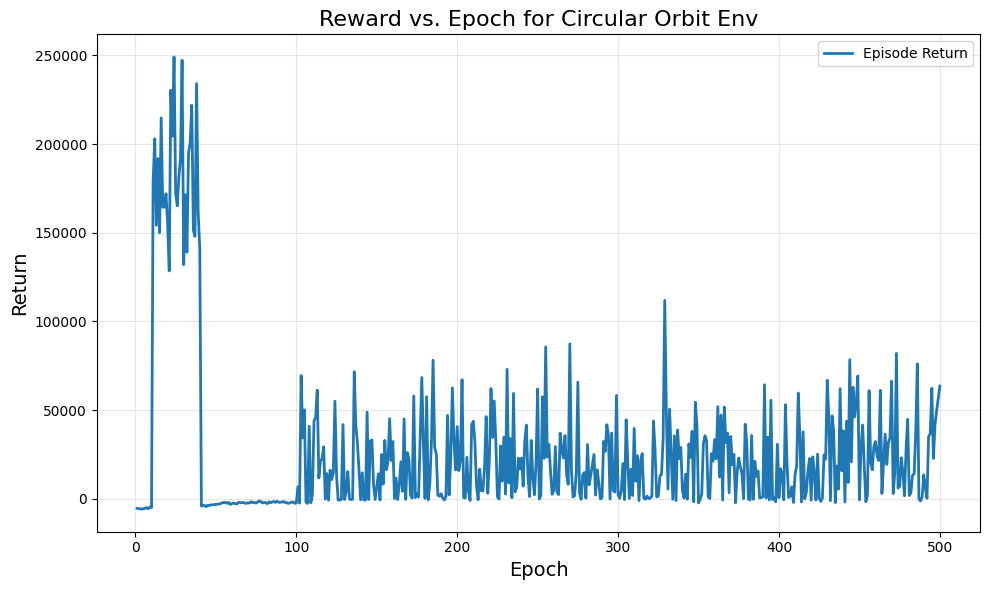

In [70]:
plot_reward(history, "Newtonian")

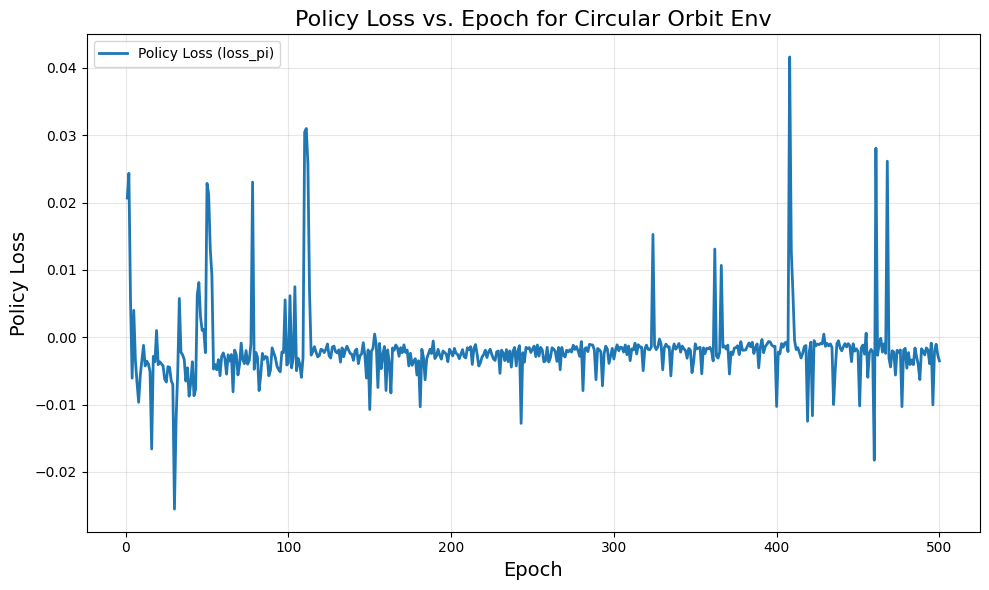

In [71]:
plot_losses(history)

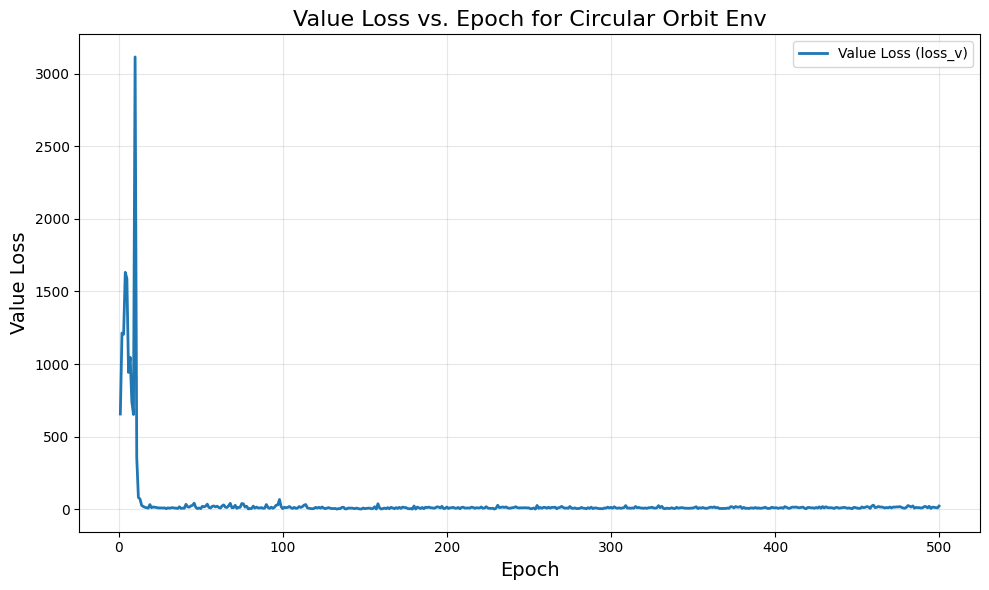

In [72]:
plot_value_losses(history)